In [2]:
import json
from typing import Any, Dict, Optional, Tuple, List
from matplotlib import pyplot as plt
from matplotlib import axes
import numpy as np
import pyperf

In [3]:
def get_data(result: Dict[str, Any]) -> Dict[str, np.ndarray]:
    results = {}

    for benchmark in result["benchmarks"]:
        if "metadata" in benchmark:
            name = benchmark["metadata"]["name"]
        else:
            name = result["metadata"]["name"]
        data = []
        for run in benchmark["runs"]:
            data.extend(run.get("values", []))
        results[name] = np.array(data, dtype=np.float64)

    return results

In [4]:
def remove_outliers(values: np.ndarray, m: int = 2):
    return values[abs(values - np.mean(values)) < m * np.std(values)]

In [5]:
def calculate_diffs(
    ref_values: List[float],
    head_values: List[float],
    outlier_rejection: bool =True,
) -> Tuple[Optional[np.ndarray], float]:
    sig, _ = pyperf._utils.is_significant(ref_values, head_values)

    if not sig:
        return None, 0.0
    else:
        if outlier_rejection:
            ref_values = remove_outliers(ref_values)
            head_values = remove_outliers(head_values)
        values = np.outer(ref_values, 1.0 / head_values).flatten()
        values.sort()
        return values, float(values.mean())

In [6]:
def plot_diff_pair(ax: axes, data: List):
    all_data = []
    violins = []

    for i, (name, values, mean) in enumerate(data):
        if values is not None:
            idx = np.round(np.linspace(0, len(values) - 1, 100)).astype(int)
            violins.append(values[idx])
            all_data.extend(values)
        else:
            violins.append([1.0])
            ax.text(1.01, i + 1, "insignificant")

    violins.append(all_data)

    violin = ax.violinplot(
        violins,
        vert=False,
        showmeans=True,
        showmedians=False,
        widths=1.0,
        quantiles=[[0.1, 0.9]] * len(violins),
    )

    violin["cquantiles"].set_linestyle(":")

    for i, values in enumerate(violins):
        if not np.all(values == [1.0]):
            mean = np.mean(values)
            ax.text(mean, i + 1.3, f"{mean:.04f}", size=8)

    return all_data

In [7]:

def plot_diff(
    ref: Dict[str, Any], head: Dict[str, Any], title: str
) -> None:
    ref_data = get_data(ref)
    head_data = get_data(head)

    combined_data = [
        (name, *calculate_diffs(ref, head_data[name]))
        for name, ref in ref_data.items()
        if name in head_data
    ]
    combined_data.sort(key=lambda x: x[2])

    _, axs = plt.subplots(figsize=(8, 2 + len(combined_data) * 0.3), layout="constrained")
    plt.axvline(1.0)
    plot_diff_pair(axs, combined_data)
    names = [x[0] for x in combined_data]
    names.append("ALL")
    axs.set_yticks(np.arange(len(names)) + 1, names)
    axs.set_ylim(0, len(names) + 1)
    axs.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    axs.xaxis.set_major_formatter(lambda val, _: f"{val:.02f}x")
    axs.grid()
    axs.set_title(title)

    return plt


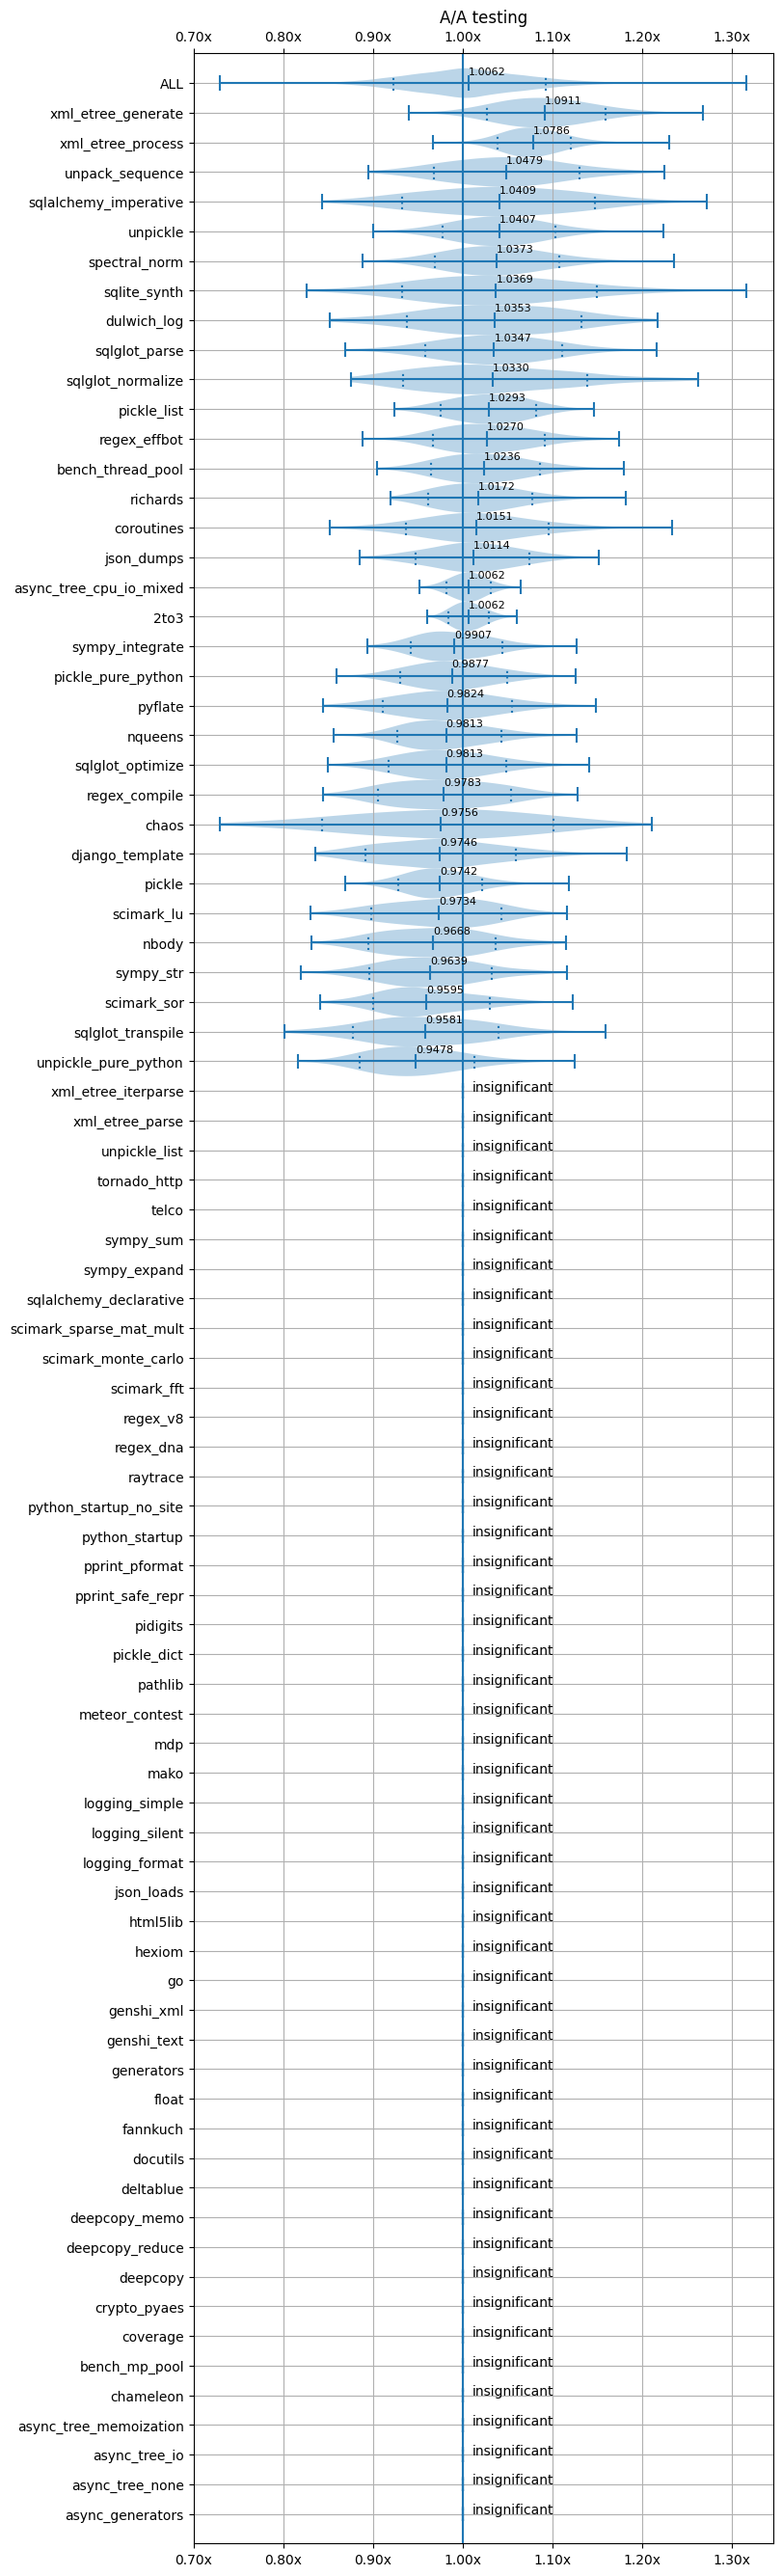

In [9]:
run = "run4"

with open(f"results/{run}/run-1.json") as fb, open(f"results/{run}/run-2.json") as fh:
    base = json.load(fb)
    head = json.load(fh)
    plot = plot_diff(base, head, "A/A testing")

plot.show()